Load Data:

We will use torchvision and torch.utils.data packages for loading the data.

In [ ]:
# Imports here
import torch 
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch import optim, nn
from torchvision import datasets, transforms, models
from collections import OrderedDict
import torchvision
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from PIL import Image
import numpy as np

data_dir = 'drive/MyDrive/big_data/Cat_Dog_data'
train_dir = data_dir + '/train'
test_dir = data_dir + '/test'
class_names = ["cat", "dog"]

# Define your transforms for the training, validation, and testing sets

train_transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

# Load the datasets with ImageFolder

train_data = torchvision.datasets.ImageFolder(train_dir , transform=train_transform)
test_data = torchvision.datasets.ImageFolder(test_dir, transform=test_transform)

# Using the image datasets and the trainforms, define the dataloaders

trainloader = torch.utils.data.DataLoader(train_data, batch_size = 4, shuffle = True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=4, shuffle = False)

Training the model:


In [ ]:
# Load a pre-trained network and reset final fully connected layer
model = models.vgg16(pretrained=True)

# Freeze parameters so we don't backprop through them.
for param in model.parameters():
    param.requires_grad = False

# Use GPU if it's available.   
device= torch.device("cuda" if torch.cuda.is_available() else 'cpu')

model.to(device)
class Classifier(nn.Module):
    # Define a new, untrained feed-forward network as a classifier, using ReLU activations and dropout

    def __init__(self, input_size, output_size, hidden_layers): # (25088, 102, [1012, 512, 128])
      super().__init__()
      self.input = nn.Linear(input_size, hidden_layers[0])
      self.h2 = nn.Linear(hidden_layers[0], hidden_layers[1])
      self.h3 = nn.Linear(hidden_layers[1], hidden_layers[2])
      self.output = nn.Linear(hidden_layers[-1], output_size)
        # Dropout=20%
      self.dropout = nn.Dropout(p=0.2)
        
    def forward(self, x):    
      x = x.view(x.shape[0], -1)
      x = self.dropout(F.relu(self.input(x)))
      x = self.dropout(F.relu(self.h2(x)))
      x = self.dropout(F.relu(self.h3(x)))
      x = F.log_softmax(self.output(x),dim=1)

      return x


In [ ]:
classifier = Classifier(25088, 102, [1012, 512, 128])
model.classifier = classifier 

# We will use Adam with momentum.
optimizer = optim.Adam(model.classifier.parameters(), lr = 0.001)
criterion = nn.NLLLoss()

model.to(device)
epochs = 6
# loop over the dataset 6 times
for epoch in range(epochs):
    running_loss = 0
    
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # # forward & backward & optimize
        log = model.forward(images)
        loss = criterion(log,labels)
        loss.backward()

        optimizer.step()
        running_loss += loss.item()
        
    else:
        test_loss = 0
        accuracy = 0
        with torch.no_grad():
          model.eval() 
          for images, labels in testloader:
              images, labels = images.to(device), labels.to(device)
              log = model.forward(images)
              test_loss += criterion(log, labels)
              ps = torch.exp(log)
              top_p, top_class = ps.topk(1, dim = 1)
              equals = top_class == labels.view(*top_class.shape)
              accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
        model.train()
        print("Epoch: {} / {}..:".format(epoch+1, epochs),
            f"Train Loss: {running_loss / len(trainloader):.3f}..",
              f"test Loss: {test_loss / len(testloader):.3f}...",
              f"test accuracy: {(accuracy / len(testloader))*100:.3f}")

Epoch: 1 / 6..: Train Loss: 0.183.. test Loss: 0.048... test accuracy: 98.400
Epoch: 2 / 6..: Train Loss: 0.161.. test Loss: 0.043... test accuracy: 98.640
Epoch: 3 / 6..: Train Loss: 0.159.. test Loss: 0.046... test accuracy: 98.400
Epoch: 4 / 6..: Train Loss: 0.153.. test Loss: 0.159... test accuracy: 98.360
Epoch: 5 / 6..: Train Loss: 0.147.. test Loss: 0.093... test accuracy: 98.520
Epoch: 6 / 6..: Train Loss: 0.149.. test Loss: 0.064... test accuracy: 98.640


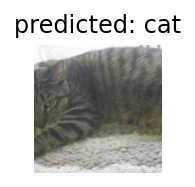

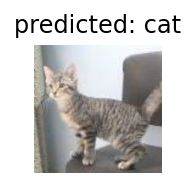

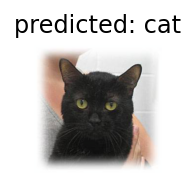

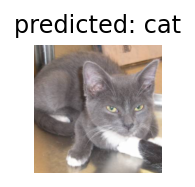

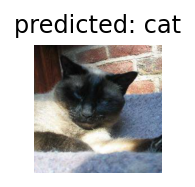

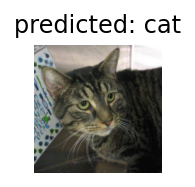

In [ ]:
# Visualizing the model predictions
# Generic function to display predictions for a 6 images

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated



def visualize_model(model, top_k=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(testloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            x, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(top_k//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == top_k:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(model)
